<a href="https://colab.research.google.com/github/HLapendery/FootballAnalysis/blob/master/LigaAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import requests as rq
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

plt.style.use('ggplot')

In [0]:
github = "https://github.com"
github_raw = "https://raw.githubusercontent.com"
url_liga = "/statsbomb/open-data/tree/master/data/matches/11"
page = rq.get(github + url_liga)
html = BeautifulSoup(page.text,'html.parser')
seasons_links = html.find_all('a',attrs = {'title':re.compile(r"^.*\.json$")})
seasons_href = [a['href'].replace('/blob','') for a in seasons_links]



def get_seasons_data(list_seasons):
  all_seasons = []
  for s in tqdm(list_seasons):
    season = pd.read_json(github_raw + s)
    for i,match in season.iterrows():
      attributes = {
            "match_id": match['match_id'],
            "season": match['season']['season_name'],
            "home": match['home_team']['home_team_name'],
            "away": match['away_team']['away_team_name'],
            "home_score": match['home_score'],
            "away_score": match['away_score'],
            "week": match['match_week']
        }
      all_seasons.append(attributes)
            
  return pd.DataFrame(all_seasons)

In [0]:
df_seasons = get_seasons_data(seasons_href)

In [0]:
df_seasons.sort_values(['season','week']).reset_index(drop = True)
df_seasons.iloc[:,1:-1]
by_season_goals = df_seasons.iloc[:,1:-1].groupby('season').sum().reset_index()

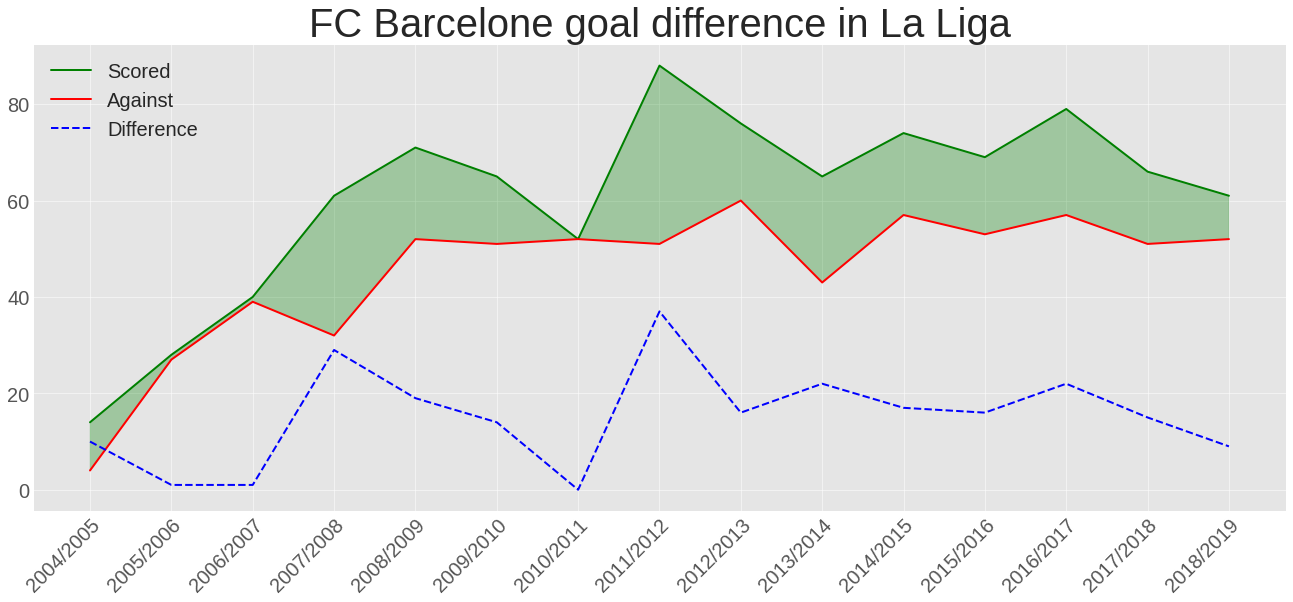

In [253]:
fig = plt.figure(figsize=(20, 8))
x = by_season_goals['season']
yh = by_season_goals['home_score']
ya = by_season_goals['away_score']
plt.plot(x, yh, 'g')
plt.plot(x, ya, 'r')
plt.plot(x,yh-ya,'b--',)
plt.fill_between(x, yh, ya,where=(yh>ya), interpolate=True,color='g', alpha=0.3)
plt.fill_between(x, yh, ya,where=(yh<ya), interpolate=True,color='r', alpha=0.3)
plt.legend(['Scored','Against','Difference'],loc='upper left',fontsize=20)
plt.xticks(fontsize=20, rotation=45,  rotation_mode="anchor", ha="right",)
plt.yticks(fontsize=20)
plt.title("FC Barcelone goal difference in La Liga",fontdict = {'fontsize' : 40})
plt.show()